## 1. Загрузка датасета

In [1]:
# !pip install -U nltk pymorphy3 pymorphy3-dicts-ru
# !pip install openTSNE

In [697]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SelectFromModel, SequentialFeatureSelector, RFE
import pymorphy3
import re
from sklearn.pipeline import Pipeline
from openTSNE import TSNE
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.preprocessing import StandardScaler

In [699]:
file_path = 'data.tsv'
df_base = pd.read_csv(file_path, sep='\t')
df = df_base.iloc[:, [1, 2]]

In [701]:
df.head()

,Replacement_period,Description
0,две недели,Acuvue Oasys (Акувью Оазис)\nДвухнедельные лин...
1,один месяц,Новые контактные линзы плановой замены AIR OPT...
2,один месяц,Ежемесячные контактные линзы TOTAL30 от Alcon ...
3,один день,Силикон-гидрогелевые контактные линзы для корр...
4,один месяц,Торические ежемесячные контактные линзы TOTAL3...


In [703]:
df.shape

(52627, 2)

In [705]:
# Удалим дубликаты записей, если они присутствуют
df = df.drop_duplicates()

In [707]:
df.shape

(96, 2)

## Векторизация набора данных

In [710]:
texts = df['Description']  
y = df['Replacement_period']

In [712]:
morph = pymorphy3.MorphAnalyzer()

In [714]:
# Функция лемматизации
def lemmatize_text(text):
    # Удаляем все кроме букв, цифр и пробелов
    text = re.sub(r'[^а-яА-Яa-zA-Z0-9\s]', '', text)
    # Разбиваем текст на слова
    words = text.split()
    # Лемматизируем каждое слово
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    # Объединяем в текст
    return ' '.join(lemmas)

In [716]:
texts_lemmatized = [lemmatize_text(text) for text in texts]

In [717]:
vectorizer = TfidfVectorizer(encoding='utf8', min_df=1, max_df=0.9)
X_tr = vectorizer.fit_transform(texts_lemmatized)

In [718]:
# Получение имён признаков
feature_names = vectorizer.get_feature_names_out()

# Преобразование в pandas.DataFrame
X = pd.DataFrame(X_tr.toarray(), columns=feature_names)
print(X)

         000   05  075   10       100        12  123индикатор  128  134   14  \
0   0.000000  0.0  0.0  0.0  0.070543  0.000000           0.0  0.0  0.0  0.0   
1   0.000000  0.0  0.0  0.0  0.000000  0.000000           0.0  0.0  0.0  0.0   
2   0.000000  0.0  0.0  0.0  0.000000  0.000000           0.0  0.0  0.0  0.0   
3   0.000000  0.0  0.0  0.0  0.000000  0.000000           0.0  0.0  0.0  0.0   
4   0.000000  0.0  0.0  0.0  0.000000  0.000000           0.0  0.0  0.0  0.0   
..       ...  ...  ...  ...       ...       ...           ...  ...  ...  ...   
91  0.000000  0.0  0.0  0.0  0.000000  0.000000           0.0  0.0  0.0  0.0   
92  0.000000  0.0  0.0  0.0  0.000000  0.068405           0.0  0.0  0.0  0.0   
93  0.000000  0.0  0.0  0.0  0.046320  0.000000           0.0  0.0  0.0  0.0   
94  0.345667  0.0  0.0  0.0  0.000000  0.000000           0.0  0.0  0.0  0.0   
95  0.347855  0.0  0.0  0.0  0.000000  0.000000           0.0  0.0  0.0  0.0   

    ...  этафилкон       это      этот 

In [721]:
X.size

142752

In [724]:
# Преобразование целевой переменной
y.unique()

array(['две недели', 'один месяц', 'один день', 'три месяца'],
      dtype=object)

In [726]:
y = np.where(y.isin(['один день', 'две недели']), 0, 1)

In [728]:
print(y)

[0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1
 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1
 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1]


In [730]:
# посчитаем дисбаланс классов
y_pd = pd.Series(y)
total = y_pd.shape[0]
class_0, class_1 = y_pd.value_counts()
print(f'Класс 0 составляет {round(class_0 / total, 3)*100}%,\n класс 1 составляет {round(class_1 / total, 3)*100}%')

Класс 0 составляет 52.1%,
 класс 1 составляет 47.9%


## Выбор наиболее значимых признаков

### Встроенные метода

#### 1) Библиотечная реализация

In [735]:
# Lasso (Logistic Regression с L1 регуляризацией)
def lasso_feature_selection(X, y, top_n=30):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
    model.fit(X, y)
    
    # Коэффициенты модели
    feature_importance = np.abs(model.coef_).sum(axis=0)
    
    # Сортируем признаки по важности
    top_features_idx = np.argsort(feature_importance)[-top_n:]
    top_features = [X.columns[i] for i in top_features_idx]
    
    return top_features

In [737]:
top_features_embedded_1 = lasso_feature_selection(X, y, top_n=30)

In [739]:
# Вывод топ-30 признаков
print("Топ-30 признаков по методу Lasso:")
print(top_features_embedded_1)

Топ-30 признаков по методу Lasso:
['900', '95', '9611333', '99', 'acuvue', 'air', 'alcon', '55', '56', '58', '59', '6pk', '78', '84', '87', 'эластичный', 'электронный', 'элемент', 'эра', 'этафилкон', 'это', 'этот', 'эффект', 'являться', 'яркий', 'ярко', 'ясно', 'ясность', 'ясный', '000']


#### 2) Собственная реализация 

In [743]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeClassifierCustom:
    def __init__(self, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, max_depth=None, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None
        self.current_leaf_count = 0
        self.feature_importances_ = None  # Массив для хранения важности признаков

    def fit(self, X, y):
        self.current_leaf_count = 0
        self.feature_importances_ = np.zeros(X.shape[1])  # Инициализируем массив с нулями
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(set(y))

        # Условия остановки
        if (
            num_samples < self.min_samples_split or
            num_classes == 1 or
            (self.max_depth is not None and depth >= self.max_depth) or
            (self.max_leaf_nodes is not None and self.current_leaf_count >= self.max_leaf_nodes)
        ):
            self.current_leaf_count += 1
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

        # Поиск лучшего разбиения
        best_feature, best_threshold, best_gain = None, None, -float("inf")
        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature_idx], threshold)
                if gain > best_gain:
                    best_feature, best_threshold, best_gain = feature_idx, threshold, gain

        # Если нет улучшений
        if best_gain == -float("inf"):
            self.current_leaf_count += 1
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

        # Увеличиваем важность признака, который был выбран для разбиения
        self.feature_importances_[best_feature] += best_gain

        # Разделение данных
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        # Проверка минимального размера листа
        if sum(left_indices) < self.min_samples_leaf or sum(right_indices) < self.min_samples_leaf:
            self.current_leaf_count += 1
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _gini(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _entropy(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))

    def _information_gain(self, y, feature_values, threshold):
        parent_loss = self._gini(y) if self.criterion == "gini" else self._entropy(y)
        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold

        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        left_loss = self._gini(y[left_indices]) if self.criterion == "gini" else self._entropy(y[left_indices])
        right_loss = self._gini(y[right_indices]) if self.criterion == "gini" else self._entropy(y[right_indices])

        child_loss = (len(y[left_indices]) / len(y)) * left_loss + (len(y[right_indices]) / len(y)) * right_loss
        return parent_loss - child_loss

    def predict(self, X):
        return np.array([self._predict_one(row, self.tree) for row in X])

    def _predict_one(self, row, node):
        if node.value is not None:
            return node.value
        if row[node.feature] <= node.threshold:
            return self._predict_one(row, node.left)
        else:
            return self._predict_one(row, node.right)

    def get_depth(self):
        return self._get_depth(self.tree)

    def _get_depth(self, node):
        if node is None or node.value is not None:
            return 0
        return 1 + max(self._get_depth(node.left), self._get_depth(node.right))

    def get_feature_importances(self):
        # Нормализуем важности признаков
        total_importance = np.sum(self.feature_importances_)
        if total_importance == 0:
            return np.zeros_like(self.feature_importances_)
        return self.feature_importances_ / total_importance

In [745]:
# Decision Tree (оценка важности признаков)
def tree_feature_selection(X, y, top_n=30):
    # Обучение дерева решений
    tree = DecisionTreeClassifierCustom(min_samples_split=5, min_samples_leaf=2, max_depth=3, max_leaf_nodes=10)
    tree.fit(X.to_numpy(), y)
    
    # Важность признаков
    feature_importances = tree.get_feature_importances()
    print(len(feature_importances))
    # Находим топ-30 признаков
    top_30_indices = np.argsort(feature_importances)[-top_n:][::-1]
    top_features = [X.columns[idx] for idx in top_30_indices]

    return top_features

In [747]:
top_features_embedded_2 = tree_feature_selection(X, y, top_n=30)

1487


In [749]:
# Вывод топ-30 признаков
print("Топ-30 признаков по методу Decision Tree:")
print(top_features_embedded_2)

Топ-30 признаков по методу Decision Tree:
['30', 'acuvue', '90', '3в1', 'звонить', 'звонок', 'здоровый', 'здоровье', 'зелёный', 'значение', 'значит', 'значительно', 'значительный', 'зона', 'заявка', 'зрение', 'зрительный', 'игра', 'играть', 'идеально', 'идеальный', 'из', 'избавить', 'избавлять', 'избежать', 'известный', 'зрачок', 'заключаться', 'заключить', 'закруглить']


In [751]:
# Сравним признаки, отобранные обоими методами:
# Находим общие признаки
common_features = set(top_features_embedded_1) & set(top_features_embedded_2)

# Выводим общие признаки и их количество
print(f"Число общих признаков: {len(common_features)} из 30")
print("Общие признаки, отобранные обоими методами:")
print(common_features)

Число общих признаков: 1 из 30
Общие признаки, отобранные обоими методами:
{'acuvue'}


### Методы фильтрации

#### 1) Библиотечная реализация

In [755]:
# Используем SelectKBest для выбора 30 лучших признаков
k_best = SelectKBest(score_func=chi2, k=30)
X_kbest = k_best.fit_transform(X, y)

# Вывод топ-30 признаков
top_features_filter_1 = X.columns[k_best.get_support()]
print("Топ-30 признаков по методу SelectKBest - chi2:")
print(top_features_filter_1.tolist())

Топ-30 признаков по методу SelectKBest - chi2:
['000', '1day', '30', '90', 'acuvue', 'air', 'biofinity', 'biotrue', 'colorblends', 'colors', 'dailies', 'daily', 'day', 'disposable', 'freshlook', 'hydraclear', 'hydraglyde', 'moist', 'month', 'myday', 'oasys', 'oneday', 'optix', 'optosoft', 'precision1', 'total30', 'with', 'ежемесячный', 'однодневный', 'цвет']


#### 2) Собственная реализация 

In [759]:
# Функция для вычисления коэффициента корреляции Пирсона
def pearson_correlation(X, y):

    # Среднее значение признаков и целевой переменной
    mean_X = np.mean(X, axis=0)
    mean_y = np.mean(y)

    # Числитель: произведение разности от каждого признака и целевой переменной от среднего
    numerator = np.sum((X - mean_X) * (y[:, np.newaxis] - mean_y), axis=0)  # Добавляем ось к y для согласования размерностей
    
    # Знаменатель: корень из произведения суммы квадратов отклонений
    denominator = np.sqrt(np.sum((X - mean_X)**2, axis=0) * np.sum((y - mean_y)**2))

    # Коэффициент корреляции для каждого признака
    correlation = numerator / denominator
    return correlation

In [761]:
# Вычисление корреляции между каждым признаком и целевой переменной
correlations = pearson_correlation(X, y)

# Создание DataFrame для хранения корреляций
correlation_df = pd.DataFrame({'feature': X.columns, 'correlation': correlations})

# Сортировка по корреляции и выбор 30 наиболее значимых признаков
top_features_filter_2 = correlation_df.sort_values(by='correlation', ascending=False).head(30)['feature'].tolist()

# Вывод топ-30 признаков
print("Топ-30 признаков по корреляции с целевой переменной:")
print(top_features_filter_2)

Топ-30 признаков по корреляции с целевой переменной:
['ежемесячный', 'цвет', 'optix', 'надевание', 'air', 'biofinity', 'оттенок', 'загрязнение', 'colors', 'плазменный', 'сделать', 'насыщенный', 'повторять', 'красота', '000', 'hydraglyde', 'alcon', 'рисунок', 'непревзойдённый', 'подойти', 'гарантия', 'сохранять', 'идеально', 'искажение', 'почувствовать', 'ощутить', 'голубой', 'тёмный', 'изменить', 'создание']


In [763]:
# Сравним признаки, отобранные обоими методами:
# Находим общие признаки
common_features = set(top_features_filter_1) & set(top_features_filter_2)

# Выводим общие признаки и их количество
print(f"Число общих признаков: {len(common_features)} из 30")
print("Общие признаки, отобранные обоими методами:")
print(common_features)

Число общих признаков: 8 из 30
Общие признаки, отобранные обоими методами:
{'hydraglyde', 'air', '000', 'цвет', 'optix', 'biofinity', 'ежемесячный', 'colors'}


### Методы-обёртки

#### 1) Библиотечная реализация

In [166]:
# Использованием SequentialFeatureSelector для отбора признаков
clf = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)

selector = SequentialFeatureSelector(clf, n_features_to_select=30, direction='forward', cv=4)
selector.fit(X, y)

# Получаем индексы признаков, которые были выбраны
selected_features_rfe = selector.support_

# Список наиболее значимых признаков
top_features_wrapper_1 = X.columns[selected_features_rfe].tolist()

# Вывод топ-30 признаков
print("Топ-30 признаков по методу SequentialFeatureSelector:")
print(top_features_wrapper_1)

Топ-30 признаков по методу SequentialFeatureSelector:
['000', '05', '075', '10', '100', '12', '123индикатор', '128', '134', '14', '16', '160', '180', '1900', '1day', '1month', '2014', '24', '25', '26230', '26231', '28', '30', '30pk', '3pk', '3zone', '90', 'acuvue', 'air', 'avaira']


#### 2) Собственная реализация 

In [173]:
# Функция для вычисления производительности модели с выбранным набором признаков
def evaluate_model(X, y, selected_features):
    model = LogisticRegression(max_iter=1000, random_state=42)
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X[selected_features], y, cv=stratified_kfold, scoring='f1')
    return np.mean(scores)
    
def wrapper_method(X, y, n_features=30, step=8, epsilon=0.001):
    selected_features = list(X.columns)
    best_score = evaluate_model(X, y, selected_features)
    
    while len(selected_features) > n_features:
        scores = []
        
        for feature in selected_features:
            temp_features = [f for f in selected_features if f != feature]
            score = evaluate_model(X, y, temp_features)
            scores.append((feature, score))
        
        # Сортируем признаки по их важности
        scores.sort(key=lambda x: x[1])
        
        # Удаляем несколько худших признаков за раз
        worst_features = [f[0] for f in scores[:step]]
        selected_features = [f for f in selected_features if f not in worst_features]
        
        # Проверяем качество модели после удаления
        current_score = evaluate_model(X, y, selected_features)
        if abs(best_score - current_score) < epsilon:  # Если улучшение незначительное, завершаем
            break
        if current_score > best_score:
            best_score = current_score
    
    return selected_features

# Применяем метод-обертку
top_features_wrapper_2 = wrapper_method(X, y, n_features=30)

In [174]:
# Вывод топ-30 признаков
print("Топ-30 признаков по своей реализации метода-обертки:")
print(top_features_wrapper_2)

Топ-30 признаков по своей реализации метода-обертки:
['чёткость', 'шесть', 'широкий', 'штука', 'экономичный', 'экран', 'эксклюзивный', 'экспериментировать', 'экстратонкий', 'эластичность', 'эластичный', 'электронный', 'элемент', 'эра', 'этафилкон', 'этот', 'эффект', 'являться', 'яркий', 'ярко', 'ясно', 'ясность', 'ясный']


In [767]:
# Сравним признаки, отобранные обоими методами:
# Находим общие признаки
common_features = set(top_features_wrapper_1) & set(top_features_wrapper_2)

# Выводим общие признаки и их количество
print(f"Число общих признаков: {len(common_features)} из 30")
print("Общие признаки, отобранные обоими методами:")
print(common_features)

Число общих признаков: 0 из 30
Общие признаки, отобранные обоими методами:
set()


### Сравнение полученных списков методов

In [770]:
common_features = set(top_features_filter_1) & set(top_features_filter_2) & set(top_features_embedded_1) & \
    set(top_features_embedded_2) & set(top_features_wrapper_1) & set(top_features_wrapper_2)

print(f"Общие признаки: {common_features}")

Общие признаки: set()


In [772]:
# Все признаки, выбранные каждым методом
all_features = []
all_features.extend(top_features_filter_1)
all_features.extend(top_features_filter_2)
all_features.extend(top_features_embedded_1)
all_features.extend(top_features_embedded_2)
all_features.extend(top_features_wrapper_1)
all_features.extend(top_features_wrapper_2)

# Подсчитываем, сколько раз каждый признак встречается
feature_counts = Counter(all_features)

# Выводим признаки, которые встречаются больше всего
top_common_features = feature_counts.most_common()
print(f"Признаки с наибольшим количеством повторений: {top_common_features}")

Признаки с наибольшим количеством повторений: [('000', 4), ('acuvue', 4), ('air', 4), ('30', 3), ('90', 3), ('1day', 2), ('biofinity', 2), ('colors', 2), ('hydraglyde', 2), ('optix', 2), ('ежемесячный', 2), ('цвет', 2), ('alcon', 2), ('идеально', 2), ('эластичный', 2), ('электронный', 2), ('элемент', 2), ('эра', 2), ('этафилкон', 2), ('этот', 2), ('эффект', 2), ('являться', 2), ('яркий', 2), ('ярко', 2), ('ясно', 2), ('ясность', 2), ('ясный', 2), ('biotrue', 1), ('colorblends', 1), ('dailies', 1), ('daily', 1), ('day', 1), ('disposable', 1), ('freshlook', 1), ('hydraclear', 1), ('moist', 1), ('month', 1), ('myday', 1), ('oasys', 1), ('oneday', 1), ('optosoft', 1), ('precision1', 1), ('total30', 1), ('with', 1), ('однодневный', 1), ('надевание', 1), ('оттенок', 1), ('загрязнение', 1), ('плазменный', 1), ('сделать', 1), ('насыщенный', 1), ('повторять', 1), ('красота', 1), ('рисунок', 1), ('непревзойдённый', 1), ('подойти', 1), ('гарантия', 1), ('сохранять', 1), ('искажение', 1), ('почувс

In [774]:
# Списки 30 признаков для каждого метода
methods = [top_features_filter_1, top_features_filter_2, top_features_embedded_1, 
           top_features_embedded_2, top_features_wrapper_1, top_features_wrapper_2]

# Создаем индикаторную матрицу
feature_names = list(set(all_features))  # Объединяем все признаки
df = pd.DataFrame(0, index=feature_names, columns=[f'Method{i+1}' for i in range(len(methods))])

# Заполняем индикаторную матрицу
for i, method in enumerate(methods):
    df.loc[method, f'Method{i+1}'] = 1

# Функция для выделения повторяющихся признаков в таблице
def highlight_repeated(val):
    return 'background-color: orange' if val == 1 else ''

# Применяем стиль
styled_df = df.style.apply(lambda x: [highlight_repeated(val) for val in x], axis=0)

# Выводим таблицу с выделением
styled_df

,Method1,Method2,Method3,Method4,Method5,Method6
84,0,0,1,0,0,0
28,0,0,0,0,1,0
звонить,0,0,0,1,0,0
month,1,0,0,0,0,0
optix,1,1,0,0,0,0
160,0,0,0,0,1,0
ясность,0,0,1,0,0,1
известный,0,0,0,1,0,0
эластичность,0,0,0,0,0,1
звонок,0,0,0,1,0,0


### Качество работы классификаторов до выбора признаков

In [778]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42, C=0.1)),
    ("Support Vector Classifier", SVC(random_state=42, C=1, kernel='rbf', gamma='scale')),
    ("Random Forest", RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2))
]

In [780]:
best_model_before = ""
best_score_before = float('-inf')

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for name, clf in classifiers:
    # Используем кросс-валидацию для оценки точности
    cv_scores = cross_val_score(clf, X, y, cv=cv)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score_before:
        best_model_before = name
        best_score_before = mean_score
    print(f"{name}: {mean_score:.4f}")

Logistic Regression: 0.7396
Support Vector Classifier: 0.9167
Random Forest: 0.8542


In [782]:
print(f"Лучшая точность до отбора признаков получена на модели {best_model_before}: {best_score_before:.4f}")

Лучшая точность до отбора признаков получена на модели Support Vector Classifier: 0.9167


### Качество работы классификаторов после выбора признаков

#### Встроенные метода

In [786]:
# Отбираем только выбранные признаки
X_selected = X[top_features_embedded_1]

In [788]:
best_selector = []
best_selector_name = ''
best_score_overall = float('-inf')

In [790]:
best_model_after = ""
best_score_after = float('-inf')
for name, clf in classifiers:
    # Используем кросс-валидацию для оценки точности
    cv_scores = cross_val_score(clf, X_selected, y, cv=cv)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score_after:
        best_model_after = name
        best_score_after = mean_score
    print(f"{name}: {mean_score:.4f}")

Logistic Regression: 0.5521
Support Vector Classifier: 0.6562
Random Forest: 0.6667


In [791]:
if best_score_after > best_score_overall:
    best_score_overall = best_score_after
    best_selector = top_features_embedded_1
    best_selector_name = 'top_features_embedded_1'

In [792]:
print(f"Лучшая точность после отбора признаков получена на модели {best_model_after}: {best_score_after:.4f}")

Лучшая точность после отбора признаков получена на модели Random Forest: 0.6667


In [794]:
# Отбираем только выбранные признаки
X_selected = X[top_features_embedded_2]

In [799]:
best_model_after = ""
best_score_after = float('-inf')
for name, clf in classifiers:
    # Используем кросс-валидацию для оценки точности
    cv_scores = cross_val_score(clf, X_selected, y, cv=cv)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score_after:
        best_model_after = name
        best_score_after = mean_score
    print(f"{name}: {mean_score:.4f}")

Logistic Regression: 0.5208
Support Vector Classifier: 0.9688
Random Forest: 0.9479


In [801]:
if best_score_after > best_score_overall:
    best_score_overall = best_score_after
    best_selector = top_features_embedded_2
    best_selector_name = 'top_features_embedded_2'

In [803]:
print(f"Лучшая точность после отбора признаков получена на модели {best_model_after}: {best_score_after:.4f}")

Лучшая точность после отбора признаков получена на модели Support Vector Classifier: 0.9688


#### Методы фильтрации

In [805]:
# Отбираем только выбранные признаки
X_selected = X[top_features_filter_1]

In [806]:
best_model_after = ""
best_score_after = float('-inf')
for name, clf in classifiers:
    # Используем кросс-валидацию для оценки точности
    cv_scores = cross_val_score(clf, X_selected, y, cv=cv)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score_after:
        best_model_after = name
        best_score_after = mean_score
    print(f"{name}: {mean_score:.4f}")

Logistic Regression: 0.7292
Support Vector Classifier: 0.9688
Random Forest: 0.9688


In [809]:
if best_score_after > best_score_overall:
    best_score_overall = best_score_after
    best_selector = top_features_filter_1
    best_selector_name = 'top_features_filter_1'

In [810]:
print(f"Лучшая точность после отбора признаков получена на модели {best_model_after}: {best_score_after:.4f}")

Лучшая точность после отбора признаков получена на модели Support Vector Classifier: 0.9688


In [815]:
# Отбираем только выбранные признаки
X_selected = X[top_features_filter_2]

In [817]:
best_model_after = ""
best_score_after = float('-inf')
for name, clf in classifiers:
    # Используем кросс-валидацию для оценки точности
    cv_scores = cross_val_score(clf, X_selected, y, cv=cv)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score_after:
        best_model_after = name
        best_score_after = mean_score
    print(f"{name}: {mean_score:.4f}")

Logistic Regression: 0.5625
Support Vector Classifier: 0.8646
Random Forest: 0.8854


In [818]:
if best_score_after > best_score_overall:
    best_score_overall = best_score_after
    best_selector = top_features_filter_2
    best_selector_name = 'top_features_filter_2'

In [819]:
print(f"Лучшая точность после отбора признаков получена на модели {best_model_after}: {best_score_after:.4f}")

Лучшая точность после отбора признаков получена на модели Random Forest: 0.8854


#### Методы-обёртки

In [821]:
# Отбираем только выбранные признаки
X_selected = X[top_features_wrapper_1]

In [822]:
best_model_after = ""
best_score_after = float('-inf')
for name, clf in classifiers:
    # Используем кросс-валидацию для оценки точности
    cv_scores = cross_val_score(clf, X_selected, y, cv=5)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score_after:
        best_model_after = name
        best_score_after = mean_score
    print(f"{name}: {mean_score:.4f}")

Logistic Regression: 0.5421
Support Vector Classifier: 0.9895
Random Forest: 0.9789


In [823]:
if best_score_after > best_score_overall:
    best_score_overall = best_score_after
    best_selector = top_features_wrapper_1
    best_selector_name = 'top_features_wrapper_1'

In [824]:
print(f"Лучшая точность после отбора признаков получена на модели {best_model_after}: {best_score_after:.4f}")

Лучшая точность после отбора признаков получена на модели Support Vector Classifier: 0.9895


In [828]:
# Отбираем только выбранные признаки
X_selected = X[top_features_wrapper_2]

In [835]:
best_model_after = ""
best_score_after = float('-inf')
for name, clf in classifiers:
    # Используем кросс-валидацию для оценки точности
    cv_scores = cross_val_score(clf, X_selected, y, cv=5)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score_after:
        best_model_after = name
        best_score_after = mean_score
    print(f"{name}: {mean_score:.4f}")

Logistic Regression: 0.5211
Support Vector Classifier: 0.5842
Random Forest: 0.4595


In [836]:
if best_score_after > best_score_overall:
    best_score_overall = best_score_after
    best_selector = top_features_wrapper_2
    best_selector_name = 'top_features_wrapper_2'

In [837]:
print(f"Лучшая точность после отбора признаков получена на модели {best_model_after}: {best_score_after:.4f}")

Лучшая точность после отбора признаков получена на модели Support Vector Classifier: 0.5842


#### Выбранный метод отбора признаков - 

In [840]:
print(f'{best_score_overall:.4f}')

0.9895


In [841]:
print(best_selector_name)

top_features_wrapper_1


In [843]:
X_selected = X[best_selector]

## Кластеризация данных

### Кластеризация данных до выбора признаков

In [846]:
def k_means(X, k, max_iters=100, tol=1e-4):
    # Преобразуем X в numpy-массив, если он является DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # Шаг 1: случайная инициализация центров кластеров
    centers = X[np.random.choice(X.shape[0], k, replace=False)]

    for i in range(max_iters):
        # Шаг 2: Присваиваем объекты к ближайшему кластеру
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)  # расстояние до центров кластеров
        labels = np.argmin(distances, axis=1)

        # Шаг 3: Пересчитываем центры кластеров
        new_centers = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Шаг 4: Проверяем условие остановки
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers

    return centers, labels

In [847]:
# Кластеризация до выбора признаков
k = 2  # Количество кластеров
centers_before, labels_before = k_means(X, k)

In [848]:
# Оценка качества кластеризации до выбора признаков
silhouette_before = silhouette_score(X, labels_before)
v_measure_before = v_measure_score(y, labels_before)

In [849]:
print(f"Silhouette Score (before feature selection): {silhouette_before:.4f}")
print(f"V-Measure (before feature selection): {v_measure_before:.4f}")

Silhouette Score (before feature selection): 0.0321
V-Measure (before feature selection): 0.0013


### Кластеризация данных после выбора признаков

In [860]:
# Кластеризация после выбора признаков
centers_after, labels_after = k_means(X_selected, k)

In [861]:
# Оценка качества кластеризации после выбора признаков
silhouette_after = silhouette_score(X_selected, labels_after) # измеряет, насколько хорошо объекты сгруппированы внутри кластеров по сравнению с ближайшими кластерами
v_measure_after = v_measure_score(y, labels_after) # оценивает соответствие кластеров истинным меткам классов

In [864]:
print(f"Silhouette Score (after feature selection): {silhouette_after:.4f}")
print(f"V-Measure (after feature selection): {v_measure_after:.4f}")

Silhouette Score (after feature selection): 0.4499
V-Measure (after feature selection): 0.2549


In [866]:
# 1 - объекты имеют в основном правильное распределение по кластерам, но все еще присутствуют некоторые пересечения между кластерами.
# 2 - указывает на слабую степень согласованности между кластерами и реальными классами,  возможно, данные не легко разделимы на четкие группы.

## Уменьшение размерности данных

### Метод PCA

In [870]:
# PCA: Уменьшаем размерность до 2
pca = PCA(n_components=2)
X_pca_before = pca.fit_transform(X)
centers_before = pca.transform(centers_before)

# PCA: Уменьшаем размерность до 2 с отобранными признаками
X_pca_after = pca.fit_transform(X_selected)
centers_after = pca.transform(centers_after)

/home/smarkelova/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/smarkelova/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


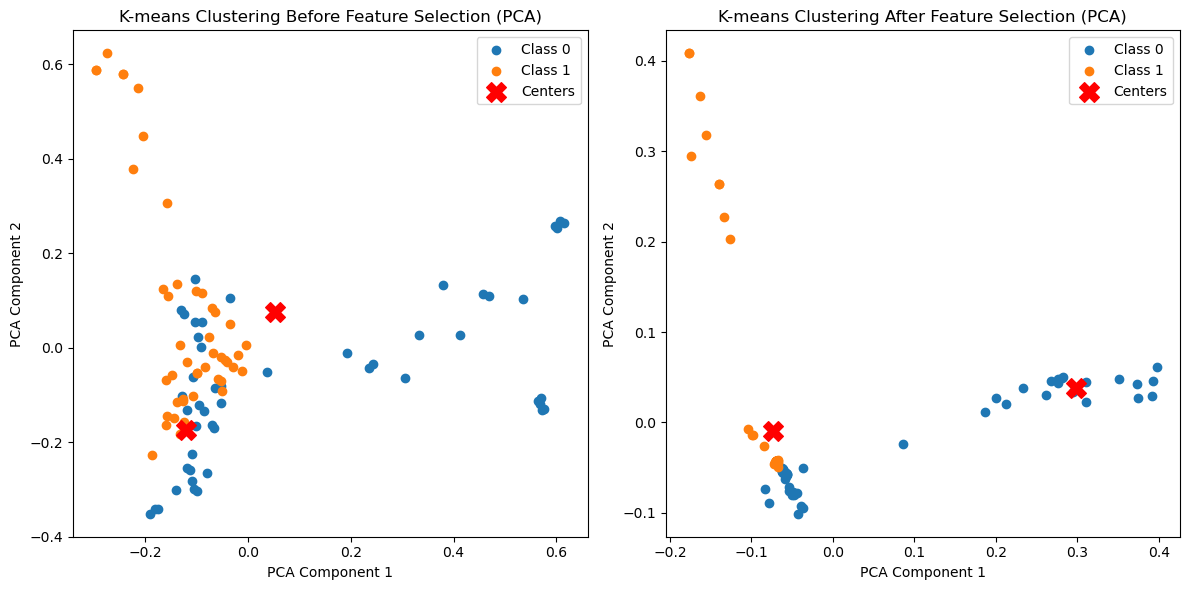

In [872]:
# До выбора признаков
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for label in np.unique(y):
    plt.scatter(
        X_pca_before[y == label, 0], X_pca_before[y == label, 1],
        label=f'Class {label}', marker='o' 
    )
plt.scatter(centers_before[:, 0], centers_before[:, 1], c='red', marker='X', s=200, label='Centers')
plt.title('K-means Clustering Before Feature Selection (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# После выбора признаков
plt.subplot(1, 2, 2)
for label in np.unique(y):
    plt.scatter(
        X_pca_after[y == label, 0], X_pca_after[y == label, 1],
        label=f'Class {label}', marker='o' 
    )
plt.scatter(centers_after[:, 0], centers_after[:, 1], c='red', marker='X', s=200, label='Centers')
plt.title('K-means Clustering After Feature Selection (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.tight_layout()
plt.show()

### Метод tSNE

In [876]:
# t-SNE: Уменьшаем размерность до 2
tsne = TSNE(
    n_components=2,
    perplexity=10,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=False
)
X_tsne_before = tsne.fit(X)

# t-SNE: Уменьшаем размерность до 2 с отобранными признаками
X_tsne_after = tsne.fit(X_selected)

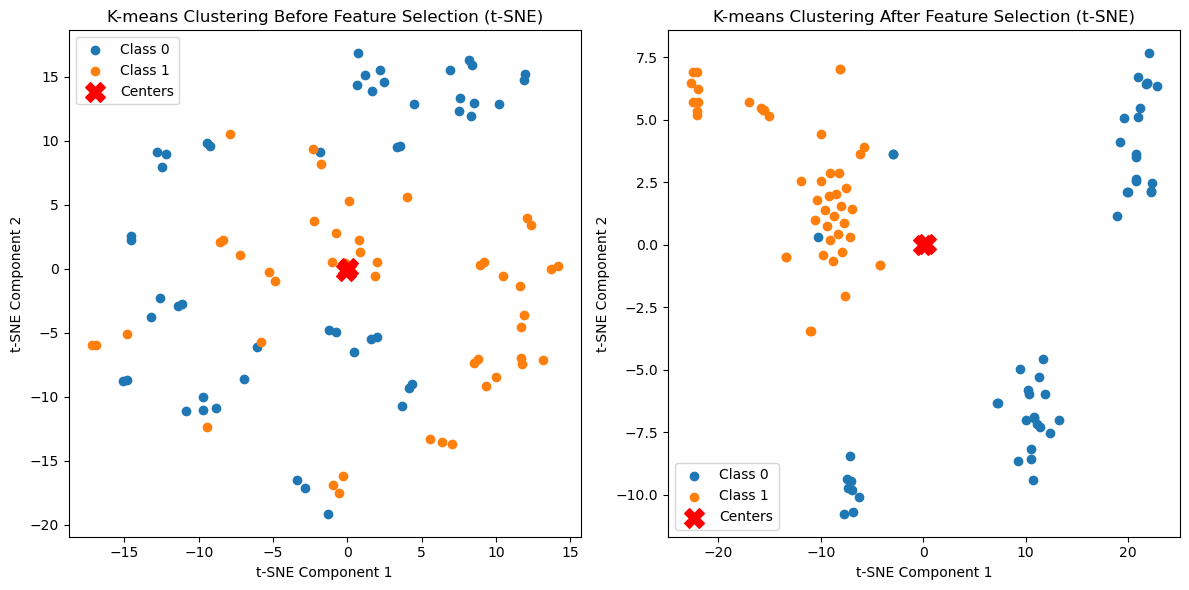

In [877]:
# Визуализация t-SNE (до выбора признаков)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for label in np.unique(y):
    plt.scatter(
        X_tsne_before[y == label, 0], X_tsne_before[y == label, 1],
        label=f'Class {label}', marker='o'
    )
plt.scatter(centers_before[:, 0], centers_before[:, 1], 
            c='red', marker='X', s=200, label='Centers')
plt.title('K-means Clustering Before Feature Selection (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

# Визуализация t-SNE (после выбора признаков)
plt.subplot(1, 2, 2)
for label in np.unique(y):
    plt.scatter(
        X_tsne_after[y == label, 0], X_tsne_after[y == label, 1],
        label=f'Class {label}', marker='o'
    )
plt.scatter(centers_after[:, 0], centers_after[:, 1], 
            c='red', marker='X', s=200, label='Centers')
plt.title('K-means Clustering After Feature Selection (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.tight_layout()
plt.show()